# CNN Libraries Requirements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0


# Loading Datasets

In [3]:
train_dataset_path = r"C:\Users\mzowe\Documents\SSSDataSets\ImageCNN\SplittedProductsDataSets\train"
validation_dataset_path = r"C:\Users\mzowe\Documents\SSSDataSets\ImageCNN\SplittedProductsDataSets\validation"

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 48

# Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2035 images belonging to 57 classes.


# Loading the Validation Datasets

In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 420 images belonging to 57 classes.


# Get The Labels

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Convert the labels dictionary to a numpy array
labels_array = np.array(list(labels.values()))


Label Mappings for classes present in the training and validation datasets

0 : 555 Carne Norte
1 : 555 Tuna Adobo
2 : 555 Tuna Afritada
3 : 555 Tuna Caldereta
4 : 555 Tuna Mechado
5 : Alaska Evaporada
6 : Argentina Corned Beef
7 : Argentina Meatloaf
8 : Baby Powder
9 : Birch Tree
10 : Camel Yellow
11 : Century Tuna 155g
12 : CloseUp Sachet
13 : Commando Matches
14 : Cup Noodles Beef
15 : Cup Noodles Seafood
16 : Datu Puti Patis
17 : Datu Puti Soysauce Bottle
18 : Datu Puti Soysauce Sachet
19 : Datu Puti Vinegar Sachet
20 : DelMonte TomatoSauce
21 : Energen Chocolate
22 : Energen Vanilla
23 : Great Taste Brown
24 : Great Taste Classic
25 : Hapee Toothpaste
26 : Hokkaido
27 : Ketchup Sachet
28 : Kopiko Black
29 : Kopiko Blanca
30 : Kopiko Brown
31 : Lucky 7 100g
32 : Lucky 7 150g
33 : LuckyMe Beef
34 : LuckyMe Chicken
35 : LuckyMe Pancit Canton
36 : LuckyMe SpicyBeef
37 : Mang Tomas
38 : Marlboro Red
39 : Mega Sardines Green
40 : Mega Sardines Red
41 : Mighty Green
42 : Milo
43 : Nescaf

# Plotting Sample Images from Training

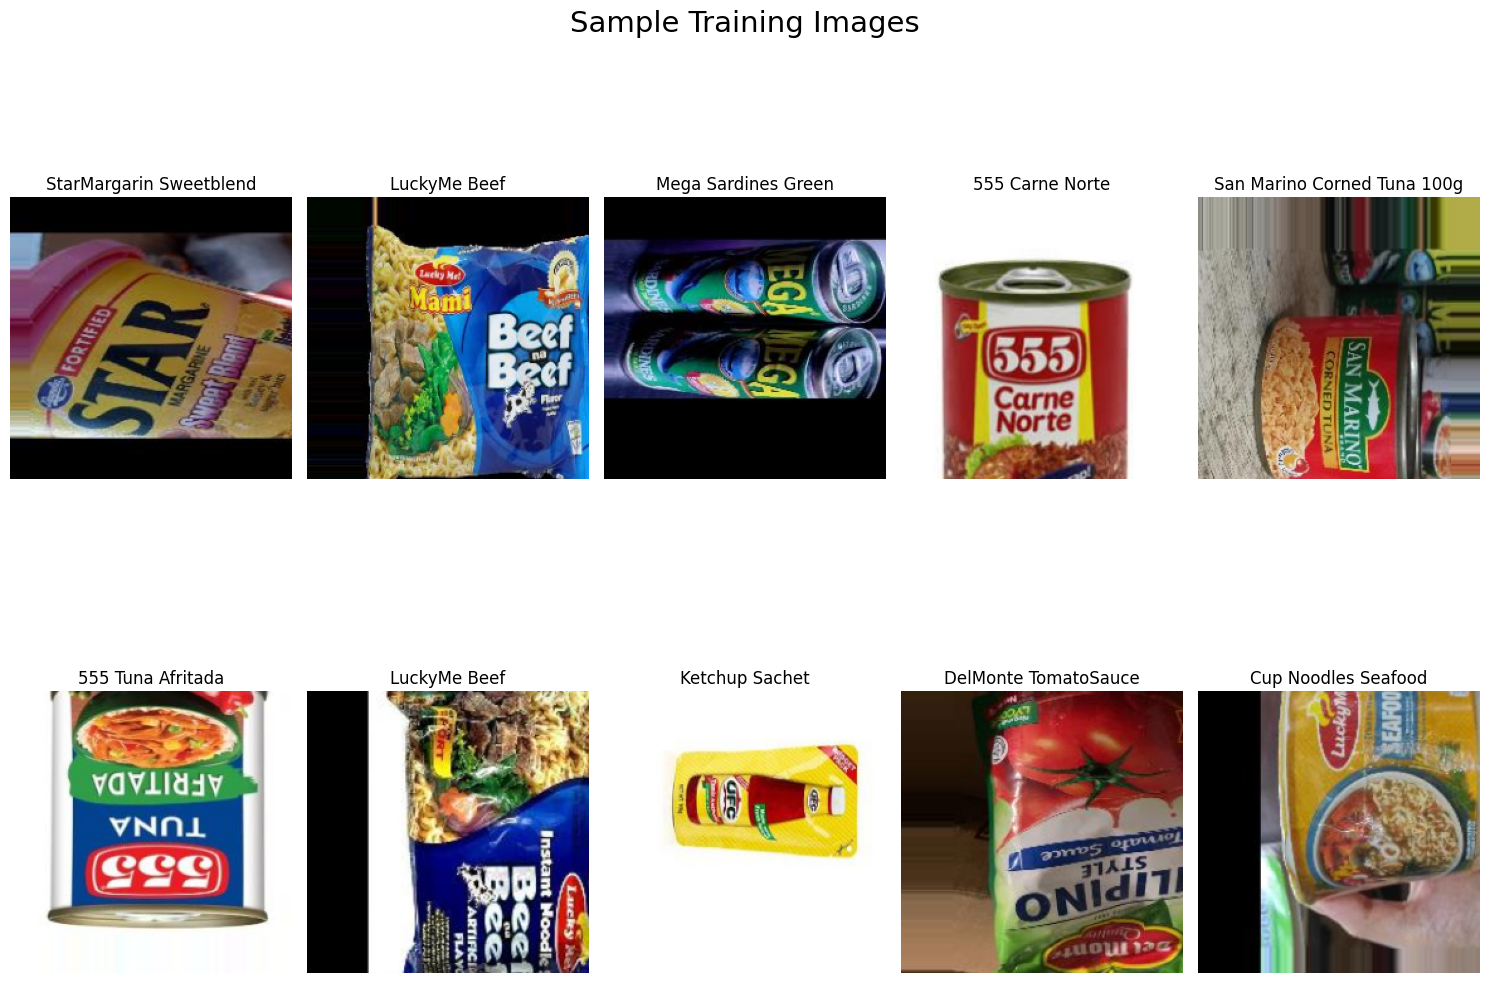

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Training a CNN Model

### Building a Convolutional Neural Network

In [9]:
def create_model():
    # Create a Sequential model
    cnn_model = Sequential([
        # Convolutional Layer 1: 128 filters, 5x5 kernel, 'valid' padding, ReLU activation
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),  # ReLU activation
        MaxPooling2D(pool_size=(2, 2)),  # Max Pooling
        BatchNormalization(),  # Batch Normalization

        # Convolutional Layer 2: 64 filters, 3x3 kernel, 'valid' padding, ReLU activation
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),  # ReLU activation
        MaxPooling2D(pool_size=(2, 2)),  # Max Pooling
        BatchNormalization(),  # Batch Normalization

        # Convolutional Layer 3: 32 filters, 3x3 kernel, 'valid' padding, ReLU activation
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),  # ReLU activation
        MaxPooling2D(pool_size=(2, 2)),  # Max Pooling
        BatchNormalization(),  # Batch Normalization

        # Flatten Layer
        Flatten(),

        # Fully Connected Layer 1: 256 units, ReLU activation
        Dense(units=256, activation='relu'),  # ReLU activation
        Dropout(0.5),  # Dropout with a rate of 0.5

        # Output Layer: 57 units for 57 classes, softmax activation
        Dense(units=57, activation='softmax'),  # Softmax activation for 57 classes
    ])

    return cnn_model


In [10]:
# Create the model
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 activation (Activation)     (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 108, 108, 64)      0

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
#Optimizer
# Create an instance of the Adam optimizer
optimizer = Adam(learning_rate=0.001)

In [14]:
# Compile the Model
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Model Training

In [15]:
#Training the Model

history = cnn_model.fit(train_generator, epochs=60, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/60
43/43 - 131s - loss: 5.7629 - accuracy: 0.0609 - val_loss: 5.8138 - val_accuracy: 0.0238 - lr: 0.0010 - 131s/epoch - 3s/step
Epoch 2/60
43/43 - 129s - loss: 4.4122 - accuracy: 0.0948 - val_loss: 8.6326 - val_accuracy: 0.0381 - lr: 0.0010 - 129s/epoch - 3s/step
Epoch 3/60
43/43 - 127s - loss: 4.2728 - accuracy: 0.1170 - val_loss: 8.3536 - val_accuracy: 0.0476 - lr: 0.0010 - 127s/epoch - 3s/step
Epoch 4/60
43/43 - 128s - loss: 4.1844 - accuracy: 0.1312 - val_loss: 5.9847 - val_accuracy: 0.0571 - lr: 0.0010 - 128s/epoch - 3s/step
Epoch 5/60
43/43 - 128s - loss: 3.9675 - accuracy: 0.1577 - val_loss: 6.3719 - val_accuracy: 0.0429 - lr: 0.0010 - 128s/epoch - 3s/step
Epoch 6/60
43/43 - 127s - loss: 3.8003 - accuracy: 0.1759 - val_loss: 6.0150 - val_accuracy: 0.0524 - lr: 0.0010 - 127s/epoch - 3s/step
Epoch 7/60
43/43 - 127s - loss: 3.4279 - accuracy: 0.2074 - val_loss: 6.4528 - val_accuracy: 0.0643 - lr: 3.1623e-04 - 127s/epoch - 3s/step
Epoch 8/60
43/43 - 127s - loss: 3.1876 - acc

Epoch 60/60
43/43 - 127s - loss: 0.5796 - accuracy: 0.8295 - val_loss: 0.3928 - val_accuracy: 0.8929 - lr: 3.1623e-05 - 127s/epoch - 3s/step


**DO NOT DELETE THIS**

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

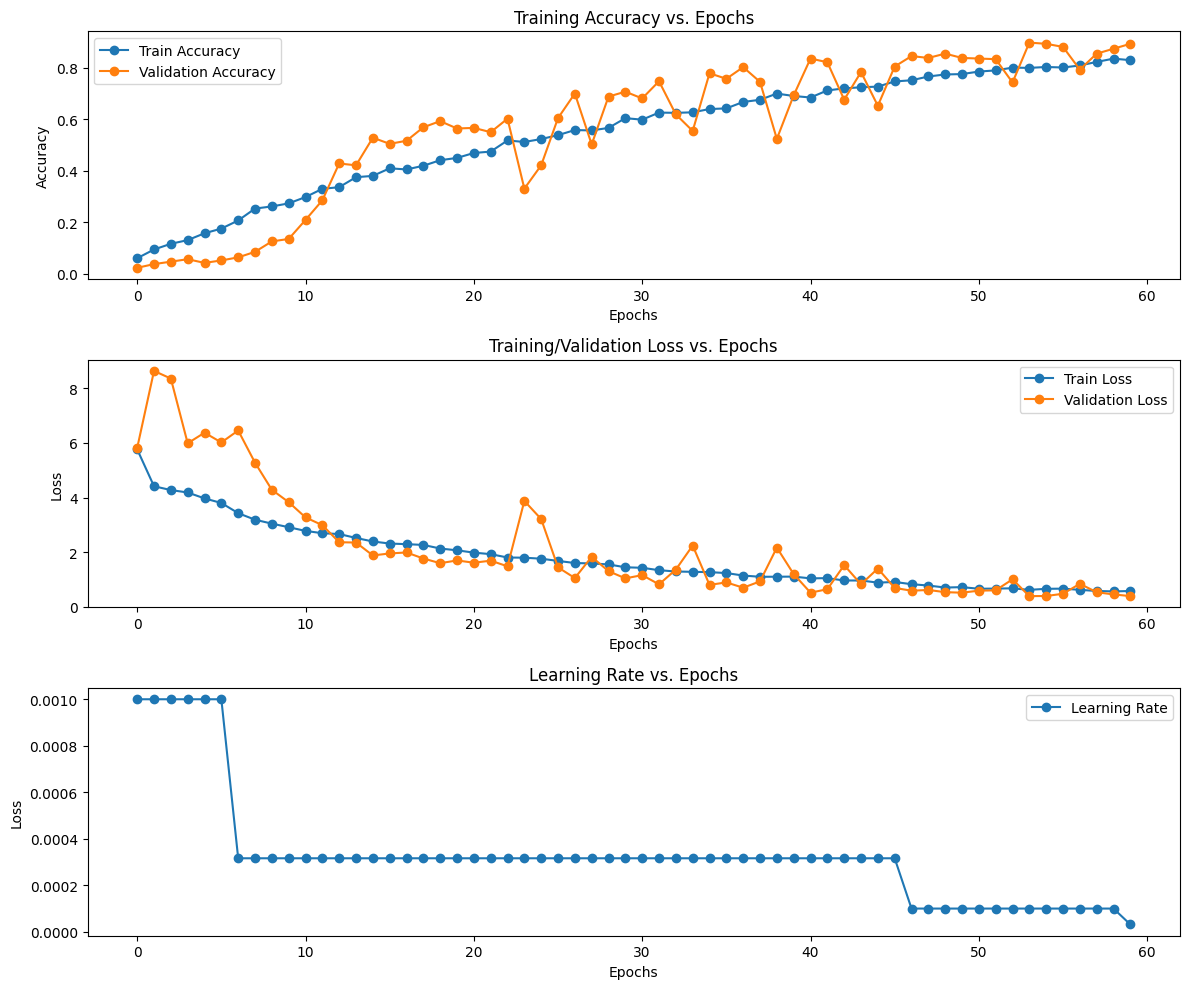

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [20]:
test_dataset = r"C:\Users\mzowe\Documents\SSSDataSets\ImageCNN\SplittedProductsDataSets\test"

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 481 images belonging to 57 classes.


In [22]:
predictions = cnn_model.predict(test_generator)

11/11 [==============================] - 6s 525ms/step


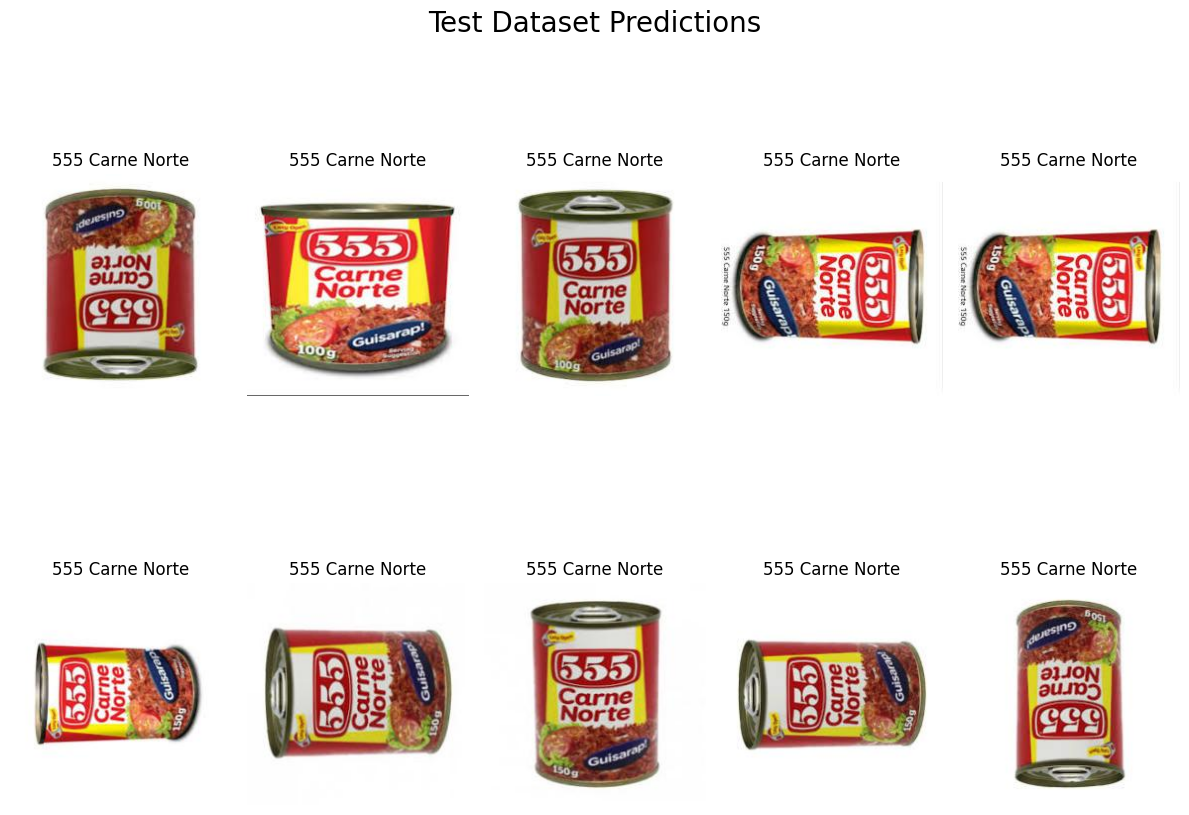

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [24]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

11/11 [==============================] - 6s 505ms/step - loss: 0.4411 - accuracy: 0.9002


In [25]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.44107893109321594
Test Accuracy: 0.9002078771591187


In [26]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [27]:
cf_mtx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_mtx)

# To find unique class labels in y_true and y_pred
unique_labels = np.unique(np.concatenate((y_true, y_pred)))

print("Unique Class Labels:")
print(unique_labels)

Confusion Matrix:
[[11  0  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  6  1]
 [ 0  0  0 ...  0  2  6]]
Unique Class Labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]


## Old Visualization Code

In [28]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

ValueError: cannot reshape array of size 3249 into shape (6,6)

# New Visualization Code

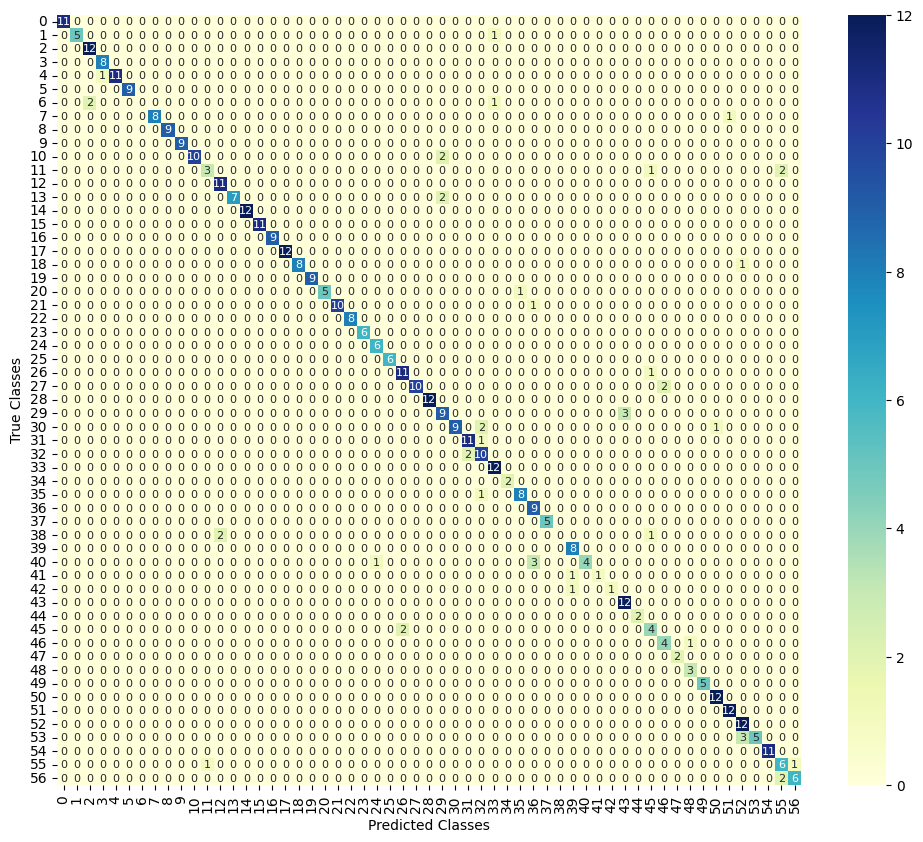

In [29]:
num_classes = len(labels)  # Determine the number of classes from the labels


group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(num_classes, num_classes)  # Dynamically reshape based on the number of classes

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels, yticklabels=labels,
           cmap="YlGnBu", annot=True, fmt="d", annot_kws={"size": 8})
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                             precision    recall  f1-score   support

            555 Carne Norte       1.00      1.00      1.00        11
             555 Tuna Adobo       1.00      0.83      0.91         6
          555 Tuna Afritada       0.86      1.00      0.92        12
         555 Tuna Caldereta       0.89      1.00      0.94         8
           555 Tuna Mechado       1.00      0.92      0.96        12
           Alaska Evaporada       1.00      1.00      1.00         9
      Argentina Corned Beef       0.00      0.00      0.00         3
         Argentina Meatloaf       1.00      0.89      0.94         9
                Baby Powder       1.00      1.00      1.00         9
                 Birch Tree       1.00      1.00      1.00         9
               Camel Yellow       1.00      0.83      0.91        12
          Century Tuna 155g       0.75      0.50      0.60         6
             CloseUp Sachet       0.85      1.00      0.92        11
           Commando Matches      

# Wrong Prediction

In [31]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [32]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

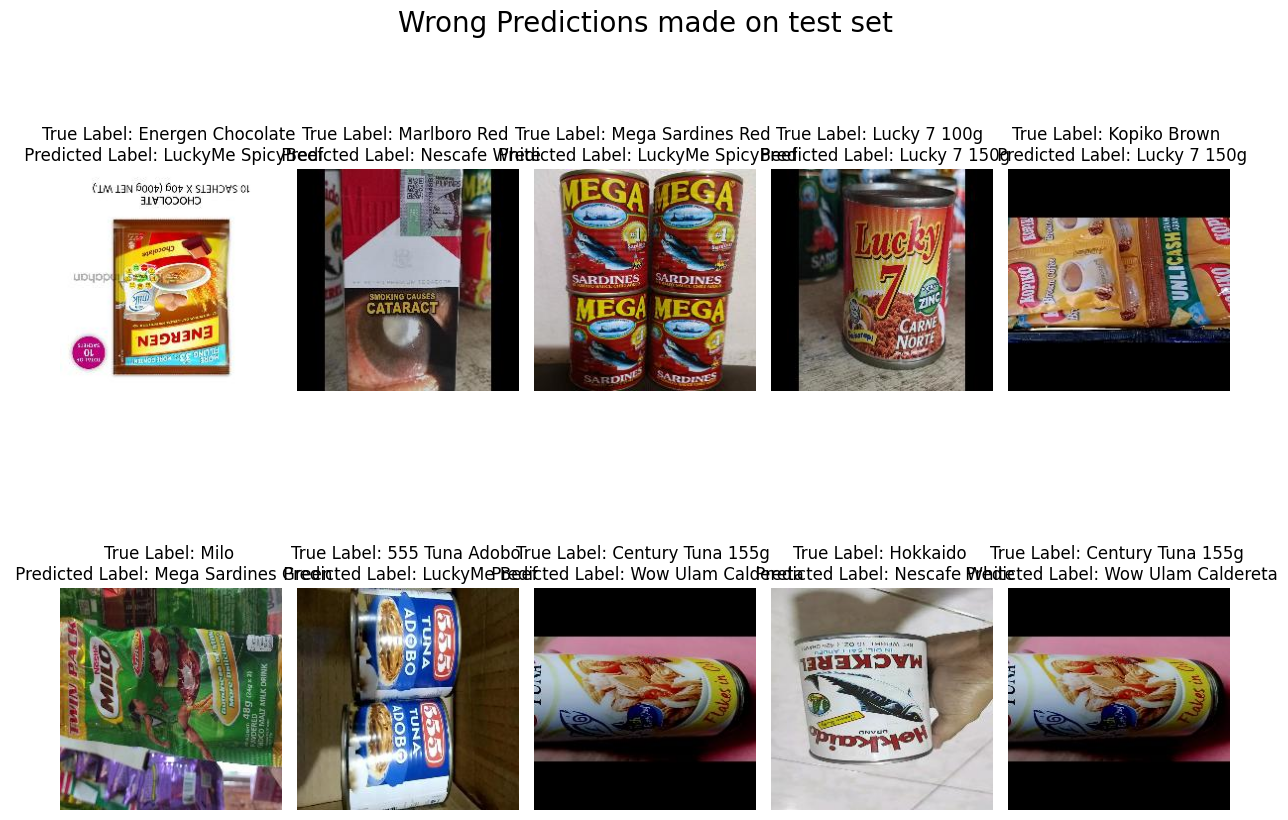

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [34]:
cnn_model.save('ProductsDatasets.keras')
print("Model Saved")

Model Saved


In [35]:
cnn_model.save('ProductsDataSets.h5')

# EfficientNet Model

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3

# Define your data directories
train_dataset_path = r"C:\Users\mzowe\Documents\SSSDataSets\ImageCNN\SplittedProductsDataSets\train"
validation_dataset_path = r"C:\Users\mzowe\Documents\SSSDataSets\ImageCNN\SplittedProductsDataSets\validation"

# Define image dimensions and batch size
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

# Load the EfficientNetB0 model (pre-trained on ImageNet)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Create a new model by adding custom top layers for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(57, activation='softmax')(x)  # Assuming you have 33 classes

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators and data augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dataset_path, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical')

# Training
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=2, callbacks=[ReduceLROnPlateau(), EarlyStopping()])

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(validation_dataset_path, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
eval_result = model.evaluate(test_generator, verbose=2)

print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])

# Plot Training Accuracy vs Epochs
plt.figure(figsize=(12, 10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Validation Loss vs Epochs
plt.figure(figsize=(12, 10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate vs Epochs
plt.figure(figsize=(12, 10))
plt.plot(history.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


44107200/44107200 [==============================] - 6s 0us/step
Found 2035 images belonging to 57 classes.
Found 420 images belonging to 57 classes.
Epoch 1/50
